In [1]:
# En primer lugar, consideraremos como banco de prueba la estación con mediciones más antiguas
# Se trata de la estacion localizada en Milan que tiene información desde 1763

import sqlite3

# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

In [1]:
from pandas import DataFrame,Series
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import time

In [6]:
# Realizamos la query
station = 'ITE00100554'

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            date, 
                            TMAX, 
                            TMIN, 
                            PRCP
                        from world_time_europa
                        where STATION = '"""+station+"';")

n = 0
for r in rows:
    n = n+1
print("Numero de registros:" + str(n))

Numero de registros:89786


In [22]:
# Tenemos una serie temporal con un total de 89,786 registros, lo que para hacer un análisis inicial es un nivel 
# muy detallado por tanto, vamos a reducir el conjunto de datos realizando la media de cada unidad por año
# Realizamos la query
station = 'ITE00100554'
result=[]

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            substr(date,1,4) as date, 
                            avg(TMAX) as TMAX, 
                            avg(TMIN) as TMIN, 
                            avg(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_europa
                        where STATION = '"""+station+"""'
                        group by substr(date,1,4)
                        order by substr(date,1,4);""")
n = 0
for r in rows:
    n = n+1
    result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
    
print("Numero de registros:" + str(n))

Numero de registros:246


In [24]:
df = DataFrame(result)

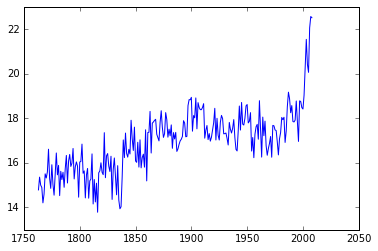

In [17]:
plt.plot(df.date,df.TMAX)

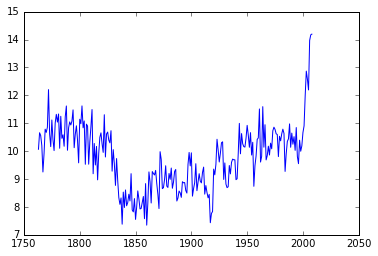

In [18]:
plt.plot(df.date,df.TMIN)

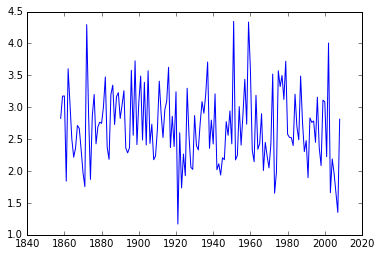

In [19]:
plt.plot(df.date,df.PRCP)

In [25]:
df.tail()

,NOBS,PRCP,TMAX,TMIN,date
241,366,2.189617,20.412251,12.578632,2004
242,365,1.962192,20.053889,12.191944,2005
243,365,1.655342,22.047397,13.967123,2006
244,331,1.350909,22.555891,14.167372,2007
245,336,2.813095,22.501791,14.192836,2008


Se observa que efectivamente en los últimos años de la serie se presentan anomalías en los 3 indicadores, 
pero no tenemos la información completa, ya que el último dato disponible de la estación data de 2008, 
por tanto tenemos que localizar una estacion en una localización con similares características para poder
extrapolar las medidas de la estación de Milan con esa nueva localizacion.  

¿Desde que fecha debemos completar?

La serie se trunca en 2008, pero los datos anómalos que se observan desde 2006 parecen indicar anomalias en las
observaciones, ya que rompe totalmente y muy bruscamente los datos.  Si observamos la serie histórica, cada año
hay 365 o 366 observaciones, salvo en los años de 2007 y 2008 que presentan 331 y 336 observaciones respectivamente,
es decir que falta al menos 1 mes de observaciones, si esa falta estuviera distribuida uniformemente por todo el año
podríamos inferir que la anomalía no es debida a esa falta de información, pero si sacamos el número de observaciones
por mes, vemos que en 2007 faltan 4 días de Julio y 30 de Octubre, un mes en el que las temperaturas se reducen,
por tanto podría explicar la subida en la temperatura media anual en 2 grados

Para 2008, se observa que faltan 30 días de Diciembre, el primer mes de invierno, que puede explicar el incremento
observado en temperaturas y reducción de precipitaciones

En 2006, a pesar de ser el primer año con anomalías, parece que no es debido al tamaño de los datos, por tanto
consideraremos que ese año la información es correcta.  Por tanto para completar la información de la serie de Milan
debemos buscar las observaciones de la estacion meteorológica más parecida desde el año 2007

In [31]:
# Para los años 2007 y 2008 revisamos qué días del año faltan
station = 'ITE00100554'

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            substr(date,1,6) as date, 
                            count(*) as NOBS
                        from world_time_europa
                        where STATION = '"""+station+"""' and date >= "20070101" and date <= "20081231"
                        group by substr(date,1,6)
                        order by substr(date,1,6);""")
result_2007=[]
result_2008=[]
for r in rows:
    if r[0] <= "200712":
        result_2007.append({"date":r[0],"NOBS":r[1]})
    else:
        result_2008.append({"date":r[0],"NOBS":r[1]})

In [32]:
df_2007 = DataFrame(result_2007)
df_2008 = DataFrame(result_2008)

In [33]:
df_2007

,NOBS,date
0,31,200701
1,28,200702
2,31,200703
3,30,200704
4,31,200705
5,30,200706
6,27,200707
7,31,200708
8,30,200709
9,1,200710


In [34]:
df_2008

,NOBS,date
0,31,200801
1,29,200802
2,31,200803
3,30,200804
4,31,200805
5,30,200806
6,31,200807
7,31,200808
8,30,200809
9,31,200810


En ambos casos falta información de 1 mes de otoño/invierno, justo cuando las temperaturas son más bajas, por tanto 
los picos observados en 2007 y 2008 no son válidos

Con los resultados anteriores, y para poder completar la historia completa de la estacion, es necesario buscar la estacion mas cercana a los resultados obtenidos para completar las observaciones de la estacion a partir de 2006, se realiza la busqueda para cada uno de los continentes, sacando el ranking de estaciones similares

In [ ]:
from datetime import datetime

# Funcion para la busqueda de estación más parecida a una dada
def findSimilarStationRanking(station, continent_table, bbdd_cursor):
    ranking=DataFrame()

    # En primer lugar se leen todas las estaciones del hemisferio sur (latitud negativa)
    df_hemis_sur = pd.read_csv("D:/master/Master-in-Data-Science/Proyecto/Datos/ghcnd-stations-cluster.csv",
                                sep=";",decimal=",")
    df_hemis_sur['station'] = df_hemis_sur.COUNTRY + df_hemis_sur.ID
    df_hemis_sur = df_hemis_sur[df_hemis_sur.LATITUDE < 0][['station']]
    
    # En primer lugar buscamos la estacion en el continente indicado
    rows = bbdd_cursor.execute("select date, TMAX, TMIN, PRCP from "+continent_table+" where station = '"+station+"';")
    
    is_south_master = False
    if max(df_hemis_sur.station.isin([station])):
        is_south_master = True
    
    result_north=[]
    result_south=[]
    for r in rows:
        # Se convierte la fecha a formato fecha
        if is_south_master:
            date_south = r[0]
            date_north = datetime.strptime(r[0], '%Y%m%d') - pd.DateOffset(months=6)
            #date_north = date_north.strftime("%Y%m%d")
            date_north = str(date_north.year) + str(date_north.month) + str(date_north.day)
        else:
            date_north = r[0]
            date_south = datetime.strptime(r[0], '%Y%m%d') + pd.DateOffset(months=6)
            #date_south = date_south.strftime("%Y%m%d")
            date_south = str(date_south.year) + str(date_south.month) + str(date_south.day)
                        
                        
        result_north.append({"date":date_north,"ROOT_TMAX":r[1],"ROOT_TMIN":r[2],"ROOT_PRCP":r[3]})        
        result_south.append({"date":date_south,"ROOT_TMAX":r[1],"ROOT_TMIN":r[2],"ROOT_PRCP":r[3]})        

    df_root_station_north = DataFrame(result_north)
    df_root_station_south = DataFrame(result_south)
    result_north = []
    result_south = []

    # Para cada continente, se itera por pais, para recuperar y comparar la informacion de cada estacion
    continentes=["antarctica","central_america","south_america","north_america","europa","africa","asia","oceania"]
    for continente in continentes:  
        print ("Iterando con el continente " + continente)
        rows = bbdd_cursor.execute("""select station, date, TMAX, TMIN, PRCP 
                    from world_time_"""+continente+" order by station;")
        
        n = 0
        result = []
        for r_stat in rows:
            # Se recuperan todas las observaciones de cada estacion
            s = r_stat[0]
            if n == 0:
                current_station = s
                
            date = r_stat[1]      
            tmax = r_stat[2]
            tmin = r_stat[3]
            prcp = r_stat[4]
                
            n = n + 1

            # Se compara con la estacion maestra, si es igual, no se hace nada, en otro caso se construye el
            # DataFrame con el detalle de las observaciones
            if current_station != station:                
                if s == current_station:
                    # Seguimos construyendo el DataFrame de la estacion
                    result.append({"station":s, "date":date,"TMAX":tmax,"TMIN":tmin,"PRCP":prcp})
                else:
                    # Llegamos a la primera observacion de la siguiente estacion
                    # El conjunto de observaciones de la estacion previa se convierten en un DataFrame
                    df_station = DataFrame(result)
                    df_station = df_station.fillna(0)
        
                    # Con la estacion recuperada, realizamos el merge con la estacion buscada
                    df_station_north = df_station.merge(df_root_station_north[["date","ROOT_TMAX","ROOT_TMIN","ROOT_PRCP"]],
                                                        on='date')
                    df_station_south = df_station.merge(df_root_station_south[["date","ROOT_TMAX","ROOT_TMIN","ROOT_PRCP"]],
                                                        on='date')
                    df_station=DataFrame()

                    # Se calcula la diferencia entre cada una de las medidas con los datos hemisferio norte
                    df_station_north["DIFF_TMAX"] = pow(df_station_north["ROOT_TMAX"]-df_station_north["TMAX"],2)
                    df_station_north["DIFF_TMIN"] = pow(df_station_north["ROOT_TMIN"]-df_station_north["TMIN"],2)
                    df_station_north["DIFF_PRCP"] = pow(df_station_north["ROOT_PRCP"]-df_station_north["PRCP"],2)
                    df_station_north["NRECORDS"] = 1
                    
                    df_station_north = df_station_north[["station","date","DIFF_TMAX","DIFF_TMIN","DIFF_PRCP","NRECORDS"]]
                    df_station_north = df_station_north.groupby("station").sum()
                    df_station_north.reset_index()
                    
                    df_station_north["TMAX"] = pow(df_station_north["DIFF_TMAX"]/df_station_north["NRECORDS"],0.5)
                    df_station_north["TMIN"] = pow(df_station_north["DIFF_TMIN"]/df_station_north["NRECORDS"],0.5)
                    df_station_north["PRCP"] = pow(df_station_north["DIFF_PRCP"]/df_station_north["NRECORDS"],0.5)
                    df_station_north['SIMILARIDAD'] = (df_station_north['TMAX']+df_station_north['TMIN'])/2
                    #df_station_north = df_station_north[["station","TMAX","TMIN","PRCP","NRECORDS"]]

                    
                    # Se calcula la diferencia entre cada una de las medidas con los datos hemisferio sur
                    df_station_south["DIFF_TMAX"] = pow(df_station_south["ROOT_TMAX"]-df_station_south["TMAX"],2)
                    df_station_south["DIFF_TMIN"] = pow(df_station_south["ROOT_TMIN"]-df_station_south["TMIN"],2)
                    df_station_south["DIFF_PRCP"] = pow(df_station_south["ROOT_PRCP"]-df_station_south["PRCP"],2)
                    df_station_south["NRECORDS"] = 1
    
                    df_station_south = df_station_south[["station","date","DIFF_TMAX","DIFF_TMIN","DIFF_PRCP","NRECORDS"]]
                    df_station_south = df_station_south.groupby("station").sum()
                    df_station_south.reset_index()
                
                    df_station_south["TMAX"] = pow(df_station_south["DIFF_TMAX"]/df_station_south["NRECORDS"],0.5)
                    df_station_south["TMIN"] = pow(df_station_south["DIFF_TMIN"]/df_station_south["NRECORDS"],0.5)
                    df_station_south["PRCP"] = pow(df_station_south["DIFF_PRCP"]/df_station_south["NRECORDS"],0.5)
                    df_station_south['SIMILARIDAD'] = (df_station_south['TMAX']+df_station_south['TMIN'])/2
                    #df_station_south = df_station_south[["station","TMAX","TMIN","PRCP","NRECORDS"]]
                    
                    # Se guardan los resultados de la comparativa

                    if len(df_station_north) > 0 and len(df_station_south > 0):
                        if df_station_north.SIMILARIDAD[0] <= df_station_south.SIMILARIDAD[0]:            
                            ranking = ranking.append(df_station_north)
                        else:
                            ranking = ranking.append(df_station_south)
                        
                    df_station_north = DataFrame()
                    df_station_south = DataFrame()
                   
                    # Se inicializan las variables para que funcione correctamente el bucle
                    result = []
                    current_station = s                    
                    result.append({"station":s, "date":date,"TMAX":tmax,"TMIN":tmin,"PRCP":prcp})
            
    ranking = ranking.sort_values(by="SIMILARIDAD")
    print (ranking.head())
    ranking.to_csv(station+"_similarity.csv")
                                           


In [ ]:
import sqlite3
import pandas as pd
from pandas import DataFrame,Series
# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

findSimilarStationRanking('ITE00100554', 'world_time_europa', cursor)

conn.close()